In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb
from google.colab import files

In [4]:
uploaded = files.upload()
data_set = pd.read_csv("Walmart Data Analysis and Forcasting.csv")

data_set['Date'] = pd.to_datetime(data_set['Date'], format='%d-%m-%Y')
weekly_sales = data_set.groupby('Date')['Weekly_Sales'].sum().reset_index()

Saving Walmart Data Analysis and Forcasting.csv to Walmart Data Analysis and Forcasting (1).csv


In [5]:
def create_features(df):
    df = df.copy()
    df['day'] = df['Date'].dt.day
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['week_of_year'] = df['Date'].dt.isocalendar().week
    df['lag_1'] = df['Weekly_Sales'].shift(1)
    df['lag_2'] = df['Weekly_Sales'].shift(2)
    df['lag_3'] = df['Weekly_Sales'].shift(3)
    df['lag_4'] = df['Weekly_Sales'].shift(4)
    df['rolling_avg_4'] = df['Weekly_Sales'].shift(1).rolling(4).mean()
    df['rolling_avg_12'] = df['Weekly_Sales'].shift(1).rolling(12).mean()

    return df

In [6]:
def add_seasonal_features(df):
    decomposition = seasonal_decompose(
        df.set_index('Date')['Weekly_Sales'],
        model='additive',
        period=52
    )
    df['trend'] = decomposition.trend.values
    df['seasonal'] = decomposition.seasonal.values
    return df

In [7]:
weekly_sales = create_features(weekly_sales)
weekly_sales = add_seasonal_features(weekly_sales)

weekly_sales.dropna(inplace=True)
X = weekly_sales.drop(['Date', 'Weekly_Sales'], axis=1)
y = weekly_sales['Weekly_Sales']

split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "LightGBM": lgb.LGBMRegressor(objective='regression', random_state=42)
}

In [8]:
results = {}
for name, model in models.items():
    if name == "LightGBM":
        tscv = TimeSeriesSplit(n_splits=5)
        for train_idx, val_idx in tscv.split(X_train):
            X_train_cv, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_train_cv, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            model.fit(X_train_cv, y_train_cv,
                      eval_set=[(X_val, y_val)],
                      callbacks=[lgb.early_stopping(50)])
        model.fit(X_train, y_train)
    else:
        model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    results[name] = {
        'predictions': y_pred,
        'mae': mean_absolute_error(y_test, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred))
    }

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 12, number of used features: 0
[LightGBM] [Info] Start training from score 44872250.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] 

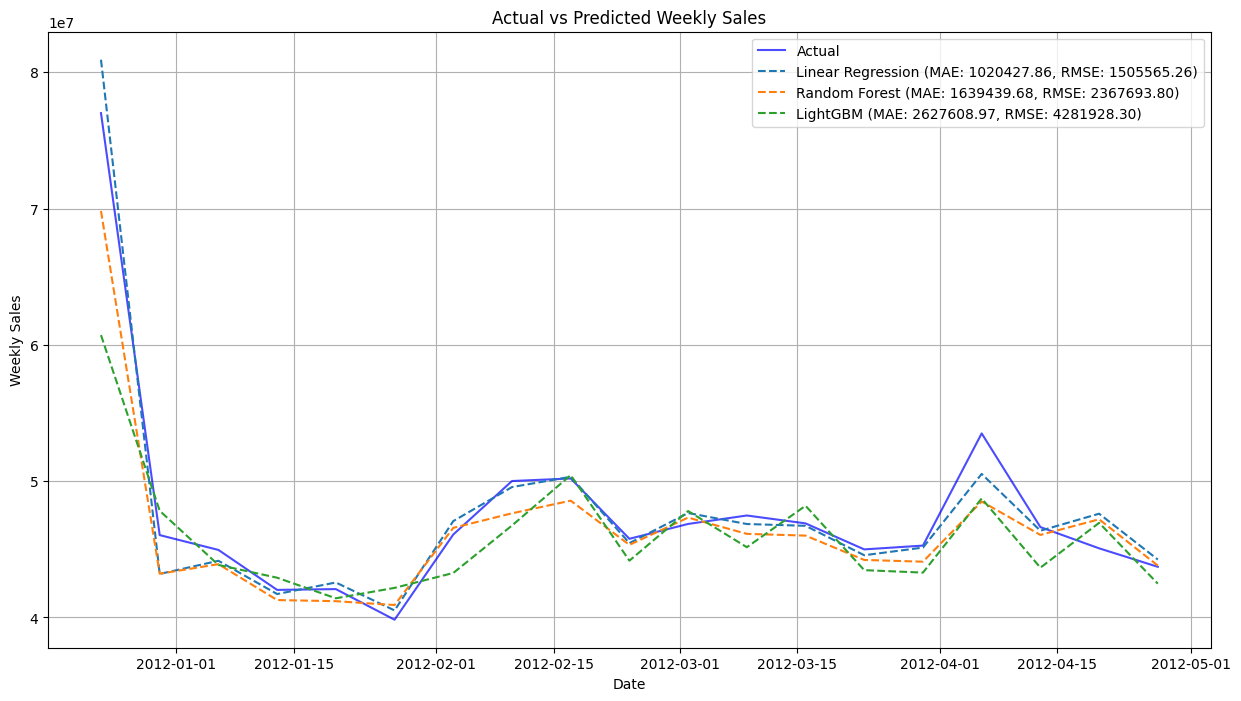

In [9]:
plt.figure(figsize=(15, 8))
plt.plot(weekly_sales['Date'].iloc[split_idx:], y_test, label='Actual', color='blue', alpha=0.7)

for name, result in results.items():
    plt.plot(weekly_sales['Date'].iloc[split_idx:], result['predictions'],
             label=f'{name} (MAE: {result["mae"]:.2f}, RMSE: {result["rmse"]:.2f})',
             linestyle='--')

plt.title('Actual vs Predicted Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
for name, result in results.items():
    print(f"{name} - MAE: {result['mae']:.2f}, RMSE: {result['rmse']:.2f}")

Linear Regression - MAE: 1020427.86, RMSE: 1505565.26
Random Forest - MAE: 1639439.68, RMSE: 2367693.80
LightGBM - MAE: 2627608.97, RMSE: 4281928.30
